In [1]:
import sys 

sys.path.insert(1, '/Users/thomaskirk/modules/svb_module')
from svb.main import run
from svb.data import HybridModel

sys.path.insert(1, '/Users/thomaskirk/modules/svb_models_asl')
from svb_models_asl import AslRestModel 

import numpy as np
import toblerone as tob 
import subprocess
import os.path as op 
import copy 
import pyvista as pv
import pandas as pd 

import matplotlib.pyplot as plt 
from matplotlib.cm import get_cmap
cmap = np.array(get_cmap('tab10').colors)
import seaborn as sns 
import helpers 
import nibabel as nib 

try:
    import tensorflow.compat.v1 as tf
    tf.disable_v2_behavior()
except ImportError:
    import tensorflow as tf

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
sph32 = tob.Surface('sph_32k.surf.gii')
cbf_truth = helpers.make_activation(sph32)
helpers.pv_plot(sph32, cbf_truth, clim=[40, 80]) 

BokehModel(combine_events=True, render_bundle={'docs_json': {'64222983-fe31-422a-843b-9f41bdc29032': {'defs': …

In [3]:
proj32 = tob.Projector.load('proj_noroi_32k.h5')
PLDS = [0.5, 0.75, 1.0, 1.25, 1.5, 1.75]

In [4]:
# Generate projectors at each vertex resolution (5k -> 32k) at 3mm iso 
# Measure number of vertices per voxel 
# Run SVB to estimate CBF on each resolution 
# Calculate MSE wrt 32k ground truth

root = 'vertex_density_sum'

lps_32_path = f'{root}/lps_32k.surf.gii'
lws_32_path = f'{root}/lws_32k.surf.gii'
sph_32_path = f'{root}/sph_32k.surf.gii'

proj32['LPS'].save(lps_32_path)
proj32['LWS'].save(lws_32_path)

densities = np.arange(6, 34, 2)
noises = np.arange(5, 65, 5)


In [5]:
for x in densities: 

    s = f"vertex_density/sph_{x}k.surf.gii"
    cmd = f"wb_command -surface-create-sphere {x*1000:d} {s}"
    subprocess.run(cmd, shell=True)

    lps = f'{root}/lps_{x}k.surf.gii'
    cmd = f"surface_resample {lps_32_path} vertex_density/sph_32k.surf.gii {x*1000:d} {lps}"
    subprocess.run(cmd, shell=True)

    lws = f'{root}/lws_{x}k.surf.gii'
    cmd = f"surface_resample {lws_32_path} vertex_density/sph_32k.surf.gii {x*1000:d} {lws}"
    subprocess.run(cmd, shell=True)

    hemi = tob.Hemisphere(lws, lps, 'L')
    ppath = f'{root}/proj_{x}k.h5'
    if not op.exists(ppath):
        p = tob.Projector(hemi, proj32.spc)
        p.save(ppath)

In [6]:
rpt = 8 

options = {
    "mode": "hybrid", 

    "learning_rate" : 0.1,
    "sample_size": 10,
    "ss_increase_factor": 4, 
    "epochs": 2000,

    "batch_size" : len(PLDS),
    "log_stream" : sys.stdout,
    "plds": PLDS, 
    "repeats": 1, 
    "casl": True, 
    "prior_type": "M",
    "display_step": 100, 
    "debug": True, 
}

for n in noises: 

    data = helpers.simulate_data(n, rpt, cbf_truth, proj32, PLDS)
    data_mean = np.stack([ data[...,(idx*rpt):(idx+1)*rpt].mean(-1) for idx in range(len(PLDS)) ], axis=-1)

    for x in densities: 

        p = tob.Projector.load(f'{root}/proj_{x}k.h5') 
        mask = (proj32.pvs()[...,:2] > 0.05).any(-1)

        runtime, svb, training_history = run(
            proj32.spc.make_nifti(data_mean), "aslrest", f"vertex_density/svb_{x}k_{n}n", 
            projector=p, mask=mask, **options)

2022-07-23 11:41:07.871951: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


INFO : SVB 0.0.2.post163
INFO : Model: ASL resting state model: 0.0.1.post40
INFO :  - Bolus duration: 1.8
INFO :  - Data is CASL/pCASL: True
INFO :  - Inversion times: [2.3, 2.55, 2.8, 3.05, 3.3, 3.55]
INFO :  - Post-labelling delays (for CASL instead of TIs): [0.5, 0.75, 1.0, 1.25, 1.5, 1.75]
INFO :  - Number of repeats - single value or one per TI/PLD: 1
INFO :  - Increase in TI/PLD per slice: 0
INFO :  - Tissue T1 value: array of shape (24392,), mean 1.1
INFO :  - Bolus arrival time: array of shape (24392,), mean 1.5
INFO :  - Bolus arrival time prior std.dev.: 1.0
INFO :  - Perfusion value to use in estimation of effective T1: array of shape (24392,), mean 0.0047
INFO :  - Blood/tissue partition coefficient. If only inferring on one tissue, default is 0.9; if inferring on both GM/WM default is 0.98/0.8 respectively. See --pcwm: array of shape (24392,), mean 0.84
INFO :  - Include WM parameters: False
INFO :  - WM perfusion: 0
INFO :  - WM arterial transit time: 1.6
INFO :  - WM T1

In [17]:
reductions = ['mean', 'sum']
for n in noises: 
    for x in densities: 
        for r in reductions: 
            inpath = f"vertex_density_{r}/svb_{x}k_{n}n/mean_ftiss_L_cortex.func.gii"
            outpath = f"vertex_density_{r}/svb_{x}k_{n}n/mean_ftiss_L_cortex_32k.func.gii"
            insph = f"vertex_density_{r}/sph_{x}k.surf.gii"
            outsph = f"vertex_density_{r}/sph_32k.surf.gii"
            cmd = f"wb_command -metric-resample {inpath} {insph} {outsph} BARYCENTRIC {outpath}"
            subprocess.run(cmd, shell=True)

In [36]:
df = [] 
thickness = np.linalg.norm(proj32['LPS'].points - proj32['LWS'].points, ord=2)
thick_mask = thickness > 0.5

for n in noises:
    for d in densities:  
        for r in reductions: 
            inpath = f"vertex_density_{r}/svb_{d}k_{n}n/mean_ftiss_L_cortex_32k.func.gii"
            c = nib.load(inpath).darrays[0].data
            s = ((c - cbf_truth)[thick_mask] ** 2).sum()
            df.append({'noise': n, 'density': d, 'reduction': r, 'cbf': c, 'ssd': s})

df = pd.DataFrame(df)
# df = df.set_index(['noise', 'density', 'reduction'])

In [19]:
helpers.pv_plot(sph32, df.loc[35, 22, 'mean'].cbf, clim=[40, 80]) 

BokehModel(combine_events=True, render_bundle={'docs_json': {'82f97c4a-6f67-4938-9a41-bec7f562cad5': {'defs': …

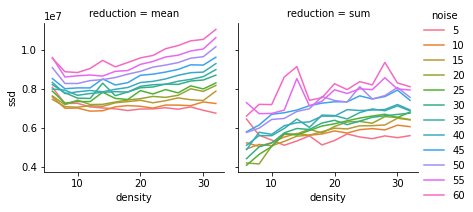

In [33]:
g = sns.FacetGrid(df.reset_index(), col='reduction', hue='noise')
g.map_dataframe(sns.lineplot, x='density', y='ssd')
g.add_legend()
# ax.set_title("SSD error for 1-neighbourhood Laplacian")
# ax.set_ylabel('SSD error')
# ax.set_xlabel('Cortical surface resolution (x1000)')
# ax.legend(noises, ncol=2, title='Noise')


In [38]:
df.head()

,noise,density,reduction,cbf,ssd
0,5,6,mean,"[33.594246, 62.154675, 46.019894, 51.123795, 3...",8.062220e+06
1,5,6,sum,"[31.622423, 55.184258, 48.984188, 49.953262, 2...",6.449286e+06
2,5,8,mean,"[37.615437, 64.8622, 42.990017, 48.469826, 41....",7.244605e+06
3,5,8,sum,"[34.990906, 62.662514, 45.756706, 51.813778, 2...",5.625713e+06
4,5,10,mean,"[40.40481, 60.742077, 42.76261, 51.573166, 48....",7.254272e+06


In [66]:
df2 = df[['noise', 'density', 'reduction', 'ssd']]
df2 = df.loc[df.reduction == 'mean'][['noise', 'density', 'ssd']]
df2.pivot(index='noise', columns='density', values='ssd')

density,6,8,10,12,14,16,18,20,22,24,26,28,30,32
noise,,,,,,,,,,,,,,
5,8.062220e+06,7.244605e+06,7.254272e+06,7.069918e+06,7.017774e+06,6.972615e+06,6.886204e+06,6.964130e+06,6.967831e+06,7.028700e+06,6.952591e+06,7.069878e+06,6.898092e+06,6.750987e+06
10,7.582090e+06,7.003978e+06,7.011676e+06,6.854502e+06,6.873281e+06,7.075086e+06,7.138236e+06,7.101058e+06,7.010634e+06,7.165059e+06,7.162324e+06,7.134877e+06,7.323101e+06,7.245012e+06
15,7.454485e+06,7.080620e+06,7.055760e+06,7.131922e+06,7.100450e+06,7.279378e+06,7.340735e+06,7.408491e+06,7.280792e+06,7.388117e+06,7.530941e+06,7.436207e+06,7.397514e+06,7.873372e+06
20,7.631309e+06,7.184254e+06,7.418988e+06,7.191241e+06,7.201214e+06,7.319269e+06,7.425202e+06,7.491368e+06,7.606948e+06,7.556867e+06,7.664786e+06,7.995026e+06,7.862873e+06,8.167506e+06
25,7.874889e+06,7.263462e+06,7.343582e+06,7.341072e+06,7.818770e+06,7.503567e+06,7.449848e+06,7.901544e+06,7.730934e+06,7.955721e+06,7.788603e+06,8.144987e+06,7.987602e+06,8.292988e+06
30,8.204646e+06,7.792985e+06,7.520198e+06,7.501994e+06,8.282418e+06,7.642955e+06,7.833135e+06,8.046430e+06,8.088398e+06,8.236474e+06,8.219422e+06,8.391740e+06,8.443926e+06,8.690557e+06
35,7.982325e+06,7.925888e+06,7.662600e+06,7.753724e+06,7.813270e+06,7.848661e+06,7.829882e+06,8.122171e+06,8.202650e+06,8.227510e+06,8.381108e+06,8.475720e+06,8.617256e+06,8.973706e+06
40,8.320758e+06,7.748854e+06,7.842709e+06,7.908866e+06,7.841035e+06,7.970210e+06,8.061900e+06,8.314265e+06,8.374346e+06,8.498559e+06,8.683791e+06,8.817416e+06,8.847638e+06,9.280980e+06
45,8.515708e+06,8.000838e+06,8.040383e+06,8.039875e+06,8.500024e+06,8.189590e+06,8.309491e+06,8.684600e+06,8.741838e+06,8.849817e+06,8.983116e+06,9.218662e+06,9.205221e+06,9.606131e+06


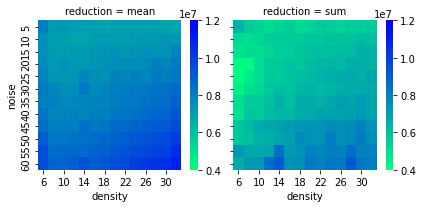

In [79]:
def func(data, **kwargs): 
    data = data.pivot(index='noise', columns='density', values='ssd')
    sns.heatmap(data, **kwargs)

g = sns.FacetGrid(df[['noise', 'density', 'reduction', 'ssd']], col='reduction')
g.map_dataframe(func, cmap="winter_r", vmin=4e6, vmax=1.2e7)
# g.add_legend()
# sns.heatmap(data=df.reset_index().pivot(index='noise', columns='density', values='ssd'), cmap="winter_r", vmax=1.1e7)

In [88]:
nstride = 2
dstride = 3

pl = pv.Plotter(shape=(2*noises[::nstride].size, densities[::dstride].size), 
                window_size=(1200,2000))

def make_mesh(surface): 
    faces = 3 * np.ones((surface.tris.shape[0], 4), dtype=int)
    faces[:,1:] = surface.tris 
    mesh = pv.PolyData(surface.points, faces=faces)
    return mesh 

mesh = make_mesh(sph32)

df2 = df.set_index(['noise', 'density', 'reduction'])
for nidx,n in enumerate(noises[::nstride]): 
    for didx, d in enumerate(densities[::dstride]): 
        for ridx,r in enumerate(reductions): 

            pl.subplot(2*nidx + ridx,didx)
            m = copy.deepcopy(mesh).rotate_z(240, inplace=False)
            actor = pl.add_mesh(m, scalars=df2.loc[n, d, r].cbf, clim=[40,80])
            pl.add_title(f'{d}k, noise {n}, reduce {r}')


pl.show(jupyter_backend='panel')

BokehModel(combine_events=True, render_bundle={'docs_json': {'6a4b675e-8602-4e8a-9c8c-1a6824e0c66e': {'defs': …